In [1]:
%cd ..

c:\Users\esper\Desktop\injury_forecasting


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd

In [4]:
from src.aggregation import (
    aggregate_panel,
    check_panel_balance
)

from src.config import (
    DATA_DIR,
    RESULTS_DIR,
    FIGURES_DIR
)

from src.plotting import (
    set_plot_style
)

set_plot_style()

In [5]:
df = pd.read_csv(
    DATA_DIR / "processed" / "federal_df.csv", 
    parse_dates=['EventDate'], 
    low_memory=False)

df.shape

(96393, 27)

In [ ]:
df.head()

## Monthly resolution / without exogenous features

In [6]:
monthly_panel = aggregate_panel(
    df,
    date_col='EventDate',
    group_col='State',
    target_cols=("Hospitalized",),
    freq="MS",
    agg='sum',
    complete_panel=True
)

monthly_panel.head(), monthly_panel.shape

(     State       Date  Hospitalized
 0  ALABAMA 2015-01-01          14.0
 1  ALABAMA 2015-02-01          15.0
 2  ALABAMA 2015-03-01          22.0
 3  ALABAMA 2015-04-01          21.0
 4  ALABAMA 2015-05-01          23.0,
 (3660, 3))

In [ ]:
monthly_panel.to_csv(
    DATA_DIR / "processed" / "monthly_panel.csv", index=False)

In [7]:
balance_info = check_panel_balance(
    monthly_panel,
    group_col='State',
    date_col='Date'
)

balance_info

{'is_balanced': True,
 'n_groups': 30,
 'n_periods': 122,
 'rows_expected': 3660,
 'rows_actual': 3660,
 'periods_per_group': State
 ALABAMA                 122
 ARKANSAS                122
 COLORADO                122
 CONNECTICUT             122
 DELAWARE                122
 DISTRICT OF COLUMBIA    122
 FLORIDA                 122
 GEORGIA                 122
 IDAHO                   122
 ILLINOIS                122
 KANSAS                  122
 LOUISIANA               122
 MAINE                   122
 MASSACHUSETTS           122
 MISSISSIPPI             122
 MISSOURI                122
 MONTANA                 122
 NEBRASKA                122
 NEW HAMPSHIRE           122
 NEW JERSEY              122
 NEW YORK                122
 NORTH DAKOTA            122
 OHIO                    122
 OKLAHOMA                122
 PENNSYLVANIA            122
 RHODE ISLAND            122
 SOUTH DAKOTA            122
 TEXAS                   122
 WEST VIRGINIA           122
 WISCONSIN               12

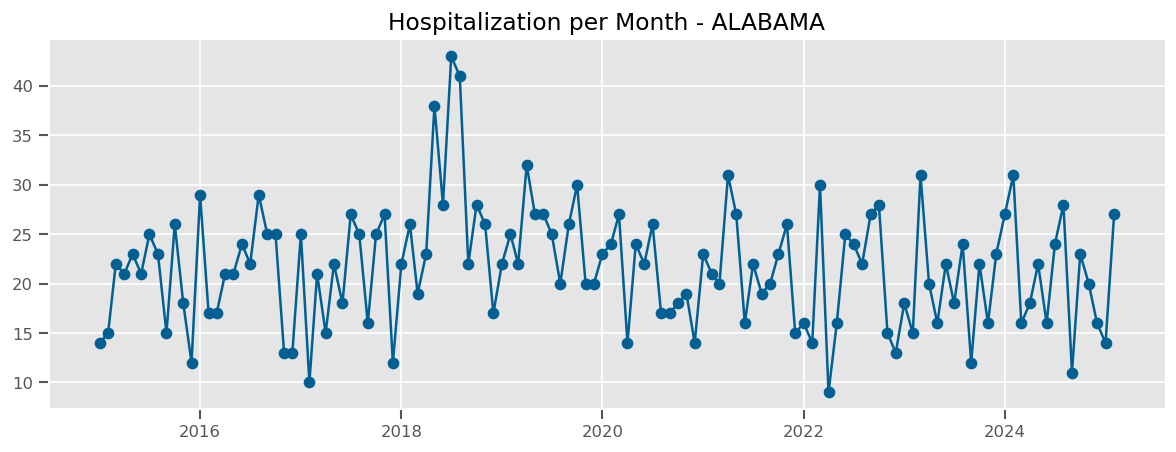

In [8]:
import matplotlib.pyplot as plt

state = "ALABAMA"

temp = monthly_panel[monthly_panel['State'] == state]

plt.figure(figsize=(12, 4))
plt.plot(temp['Date'], temp["Hospitalized"], marker='o', label=state)
plt.title(f"Hospitalization per Month - {state}")
plt.show()

In [10]:
from src.features import build_panel_features

X, y, meta = build_panel_features(
    panel_df=monthly_panel,
    target="Hospitalized",
    group_col="State",
    date_col="Date",
    freq="MS",
    add_calendar=True,
    add_lags=True,
    add_rolling=True,
    add_ewm=True,
    lags=(1, 2, 3, 6, 12),
    rolling_windows=(3, 6, 12),
    ewm_spans=(3, 6, 12),
    dropna=True,
)

X.head(), y.head(), meta.head()


(   year  month  quarter  weekofyear  Hospitalized_lag1  Hospitalized_lag2  \
 0  2016      1        1          53               12.0               18.0   
 1  2016      2        1           5               29.0               12.0   
 2  2016      3        1           9               17.0               29.0   
 3  2016      4        2          13               17.0               17.0   
 4  2016      5        2          17               21.0               17.0   
 
    Hospitalized_lag3  Hospitalized_lag6  Hospitalized_lag12  \
 0               26.0               25.0                14.0   
 1               18.0               23.0                15.0   
 2               12.0               15.0                22.0   
 3               29.0               26.0                21.0   
 4               17.0               18.0                23.0   
 
    Hospitalized_rollmean3  Hospitalized_rollmean6  Hospitalized_rollmean12  \
 0               18.666667               19.833333               

In [11]:
from src.splitting import temporal_panel_split

splits = temporal_panel_split(
    X=X,
    y=y,
    meta=meta,
    date_col='Date',
    train_end='2023-12-01',
    test_start='2024-01-01',
    test_size=12
)


In [12]:
meta.head()

,State,Date
0,ALABAMA,2016-01-01
1,ALABAMA,2016-02-01
2,ALABAMA,2016-03-01
3,ALABAMA,2016-04-01
4,ALABAMA,2016-05-01


In [13]:
print("Train last date:", splits["train"]["meta"]["Date"].max())
print("Test first date:", splits["test"]["meta"]["Date"].min())
print("Test last date:", splits["test"]["meta"]["Date"].max())

Train last date: 2023-12-01 00:00:00
Test first date: 2024-01-01 00:00:00
Test last date: 2024-12-01 00:00:00


In [ ]:
print("Train window:",
      splits["train"]["meta"]["Date"].min(),
      "→",
      splits["train"]["meta"]["Date"].max())

print("Test window:",
      splits["test"]["meta"]["Date"].min(),
      "→",
      splits["test"]["meta"]["Date"].max())

In [14]:
from src.models import get_model_configs, instantiate_models

X_train = splits["train"]["X"]
y_train = splits["train"]["y"]

model_configs = get_model_configs(
    n_samples=len(X_train),
    use_linear=True,
    use_tree=True,
    random_state=0,
    n_jobs=-1,
)

models = instantiate_models(model_configs)

list(models.keys())
# ['Ridge', 'Lasso', 'ElasticNet', 'PLS', 'XGBoost', 'LightGBM', 'CatBoost']


['Ridge', 'Lasso', 'ElasticNet', 'PLS', 'XGBoost', 'LightGBM', 'CatBoost']

In [62]:
print(model_configs)

{'Ridge': {'cls': <class 'sklearn.linear_model._ridge.Ridge'>, 'init': {'alpha': 1.0, 'random_state': 0}}, 'Lasso': {'cls': <class 'sklearn.linear_model._coordinate_descent.Lasso'>, 'init': {'alpha': 0.001, 'max_iter': 10000, 'random_state': 0}}, 'ElasticNet': {'cls': <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>, 'init': {'alpha': 0.001, 'l1_ratio': 0.5, 'max_iter': 10000, 'random_state': 0}}, 'PLS': {'cls': <class 'sklearn.cross_decomposition._pls.PLSRegression'>, 'init': {'n_components': 10}}, 'XGBoost': {'cls': <class 'xgboost.sklearn.XGBRegressor'>, 'init': {'n_estimators': 300, 'learning_rate': 0.05, 'max_depth': 3, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_lambda': 1.0, 'objective': 'reg:squarederror', 'random_state': 0, 'n_jobs': -1}}, 'LightGBM': {'cls': <class 'lightgbm.sklearn.LGBMRegressor'>, 'init': {'n_estimators': 300, 'learning_rate': 0.05, 'max_depth': 3, 'num_leaves': 7, 'subsample': 1.0, 'colsample_bytree': 1.0, 'objective': 'regression', 'reg_l

In [ ]:
X_train.head()

In [ ]:
y_train.head()

In [16]:
from src.training import train_and_predict_global_models


# 2. Train + predict
results = train_and_predict_global_models(
    models=models,
    splits=splits,
)

# Example: inspect one model's test predictions
ridge_test = results["Ridge"]["test"]
ridge_test["meta"].head()
ridge_test["y_true"].head()
ridge_test["y_pred"].head()


c:\Users\esper\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.929e+04, tolerance: 1.816e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\esper\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.996e+04, tolerance: 1.816e+02
  model = cd_fast.enet_coordinate_descent(


0    20.435962
1    21.778631
2    25.715601
3    20.683263
4    18.141568
Name: Ridge_pred_test, dtype: float64

In [17]:
from src.evaluation import compute_panel_metrics

metrics = compute_panel_metrics(
    results=results,
    group_col="State",
    metric_names=("rmse", "mae"),
)

global_train = metrics["global"]["train"]
global_test  = metrics["global"]["test"]

by_state_train = metrics["by_group"]["train"]
by_state_test  = metrics["by_group"]["test"]

print("Global test metrics:")
display(global_test)

print("Per-state test metrics (head):")
display(by_state_test.head())


Global test metrics:


,rmse,mae
model,,
CatBoost,5.315999,3.778509
ElasticNet,5.642590,3.876931
Lasso,5.642425,3.876853
LightGBM,5.494753,3.879432
PLS,5.632415,3.868233
Ridge,5.627023,3.883665
XGBoost,5.234011,3.727234


Per-state test metrics (head):


rmse       mae
State   model                         
ALABAMA CatBoost    5.822429  5.103592
        ElasticNet  6.562702  5.919843
        Lasso       6.563037  5.920081
        LightGBM    5.682661  4.953725
        PLS         6.665203  6.047013

In [41]:
from src.plotting import plot_forecast_results

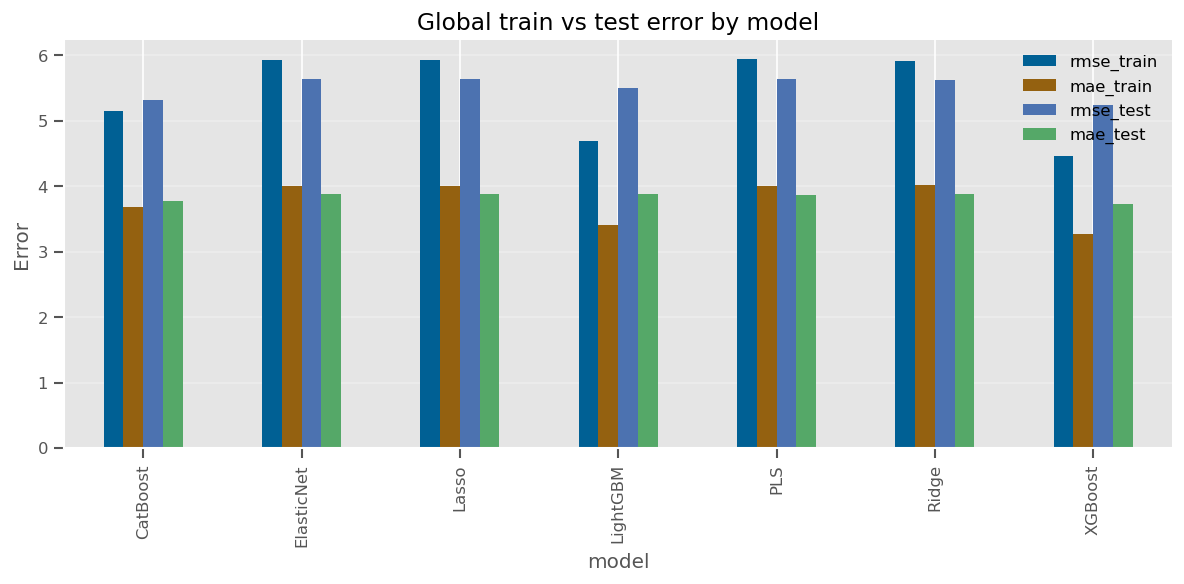

In [49]:
import matplotlib.pyplot as plt

df = global_train[["rmse", "mae"]].join(
    global_test[["rmse", "mae"]],
    lsuffix="_train",
    rsuffix="_test"
)

df.plot.bar(figsize=(10, 5))
plt.title("Global train vs test error by model")
plt.ylabel("Error")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


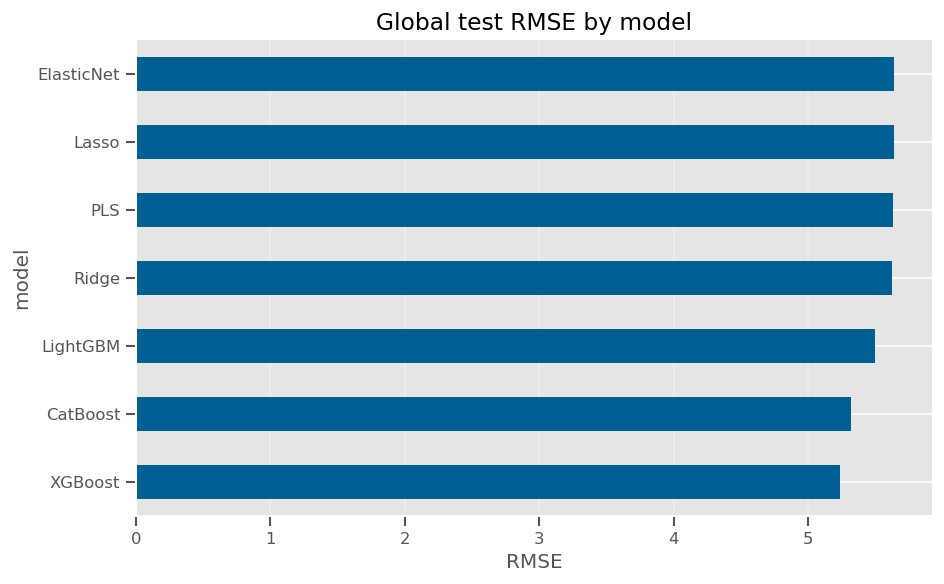

In [50]:
global_test["rmse"].sort_values().plot.barh(figsize=(8, 5))
plt.title("Global test RMSE by model")
plt.xlabel("RMSE")
plt.grid(True, axis="x", alpha=0.3)
plt.tight_layout()
plt.show()


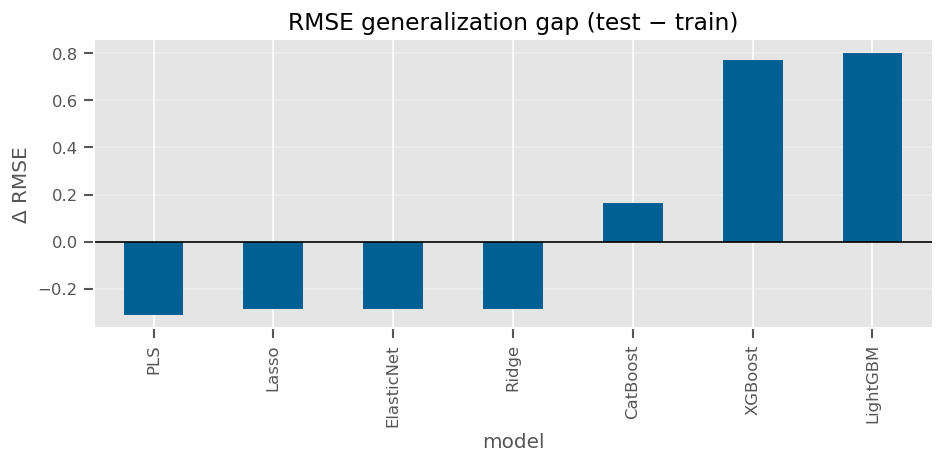

In [51]:
gap = global_test["rmse"] - global_train["rmse"]

gap.sort_values().plot.bar(figsize=(8, 4))
plt.axhline(0, color="black", linewidth=1)
plt.title("RMSE generalization gap (test − train)")
plt.ylabel("Δ RMSE")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


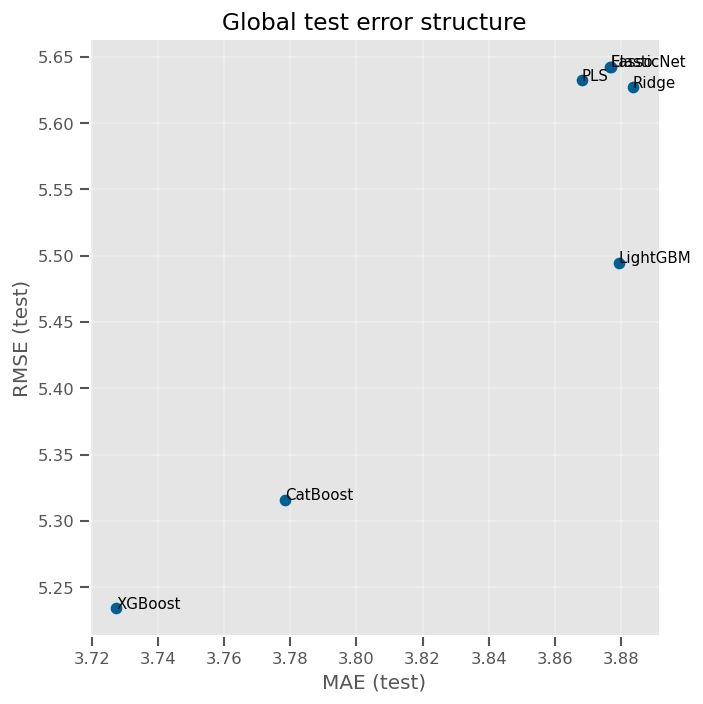

In [52]:
plt.figure(figsize=(6, 6))
plt.scatter(global_test["mae"], global_test["rmse"])

for model in global_test.index:
    plt.text(
        global_test.loc[model, "mae"],
        global_test.loc[model, "rmse"],
        model,
        fontsize=9
    )

plt.xlabel("MAE (test)")
plt.ylabel("RMSE (test)")
plt.title("Global test error structure")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


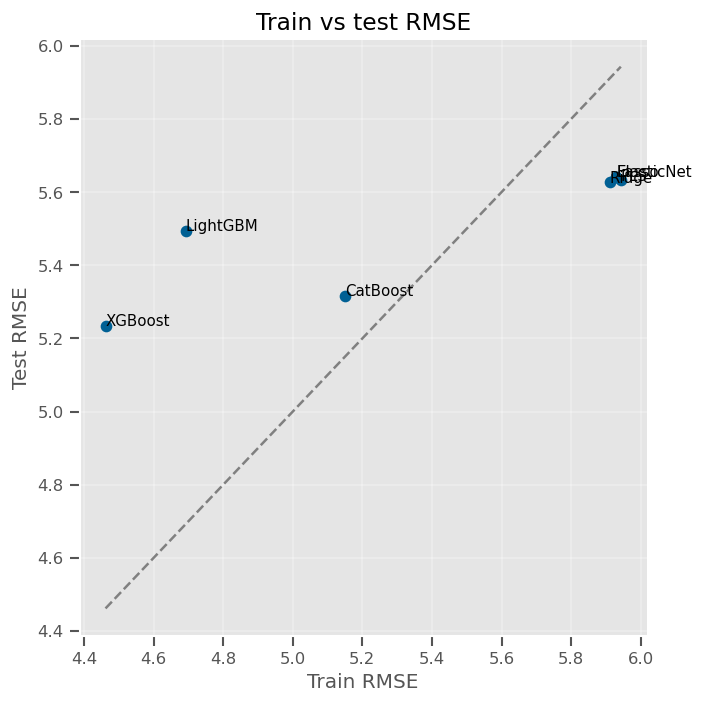

In [53]:
plt.figure(figsize=(6, 6))
plt.scatter(global_train["rmse"], global_test["rmse"])

for model in global_test.index:
    plt.text(
        global_train.loc[model, "rmse"],
        global_test.loc[model, "rmse"],
        model,
        fontsize=9
    )

plt.plot(
    [global_train["rmse"].min(), global_train["rmse"].max()],
    [global_train["rmse"].min(), global_train["rmse"].max()],
    linestyle="--",
    color="gray"
)

plt.xlabel("Train RMSE")
plt.ylabel("Test RMSE")
plt.title("Train vs test RMSE")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


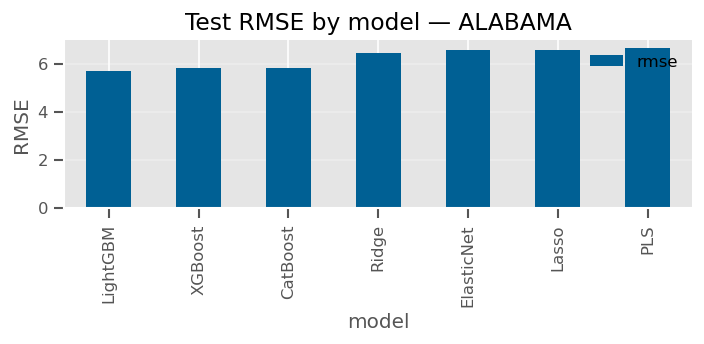

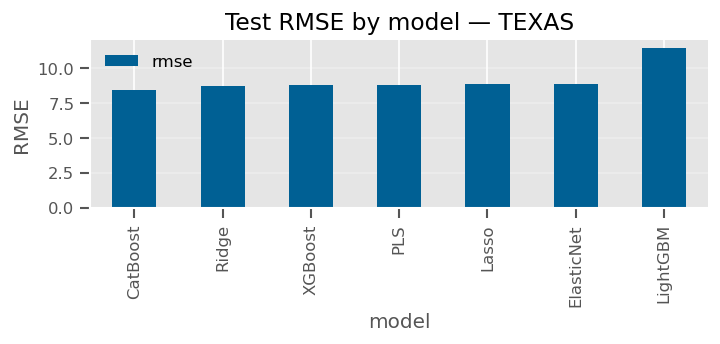

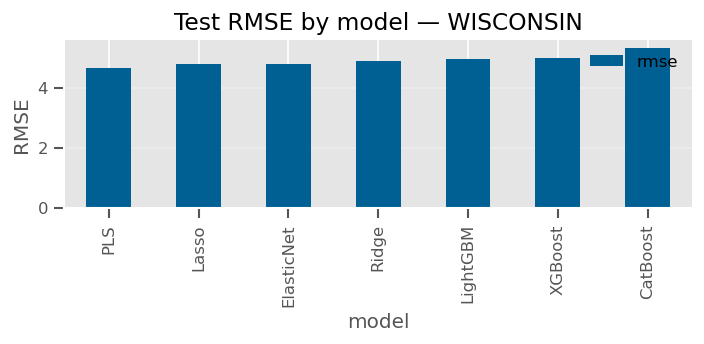

In [56]:
states = ["ALABAMA", "TEXAS", "WISCONSIN"]

for state in states:
    (
        by_state_test
        .loc[state]
        .sort_values("rmse")
        .plot.bar(y="rmse", figsize=(6, 3))
    )
    plt.title(f"Test RMSE by model — {state}")
    plt.ylabel("RMSE")
    plt.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()



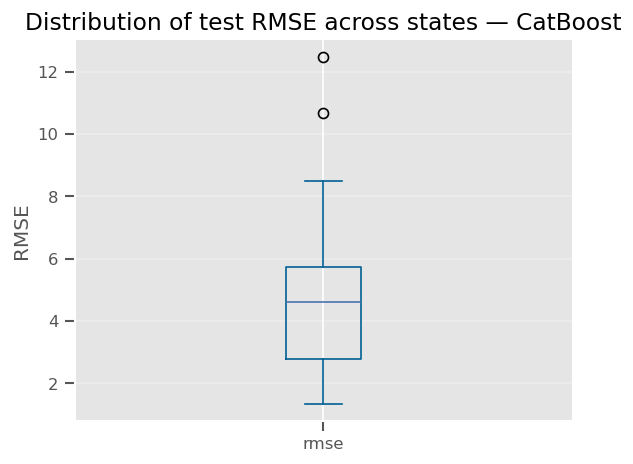

In [58]:
model = "CatBoost"

(
    by_state_test
    .query("model == @model")["rmse"]
    .plot.box(figsize=(5, 4))
)

plt.title(f"Distribution of test RMSE across states — {model}")
plt.ylabel("RMSE")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


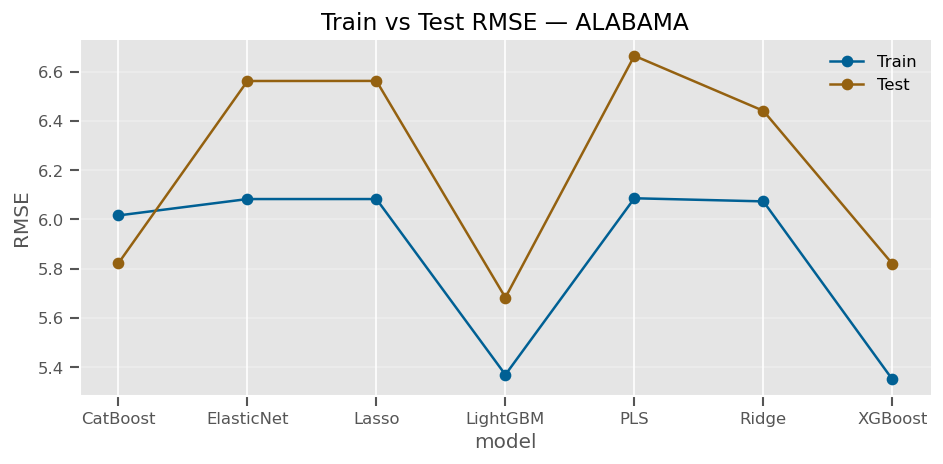

In [60]:
import matplotlib.pyplot as plt

state = "ALABAMA"

train = by_state_train.loc[state]["rmse"]
test  = by_state_test.loc[state]["rmse"]

df = train.to_frame("Train").join(test.to_frame("Test"))

df.plot(marker="o", figsize=(8, 4))
plt.title(f"Train vs Test RMSE — {state}")
plt.ylabel("RMSE")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


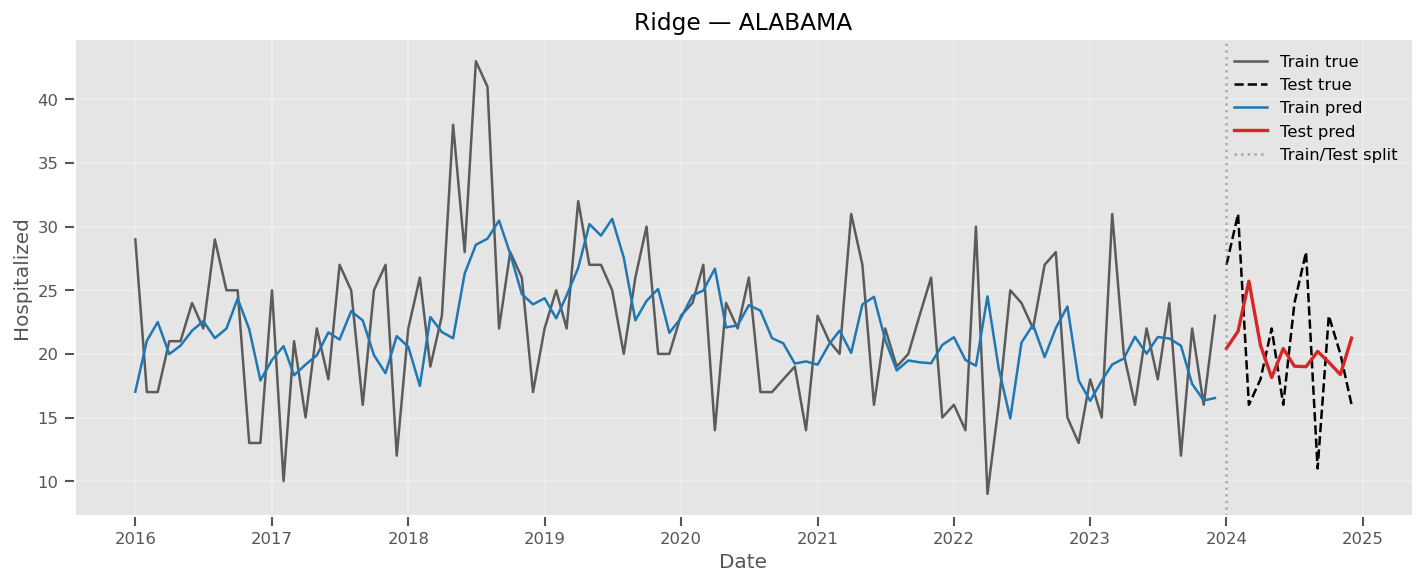

In [61]:
import matplotlib.pyplot as plt
import pandas as pd

model = "Ridge"
state = "ALABAMA"

res = results[model]

# --- TRAIN ---
meta_tr = res["train"]["meta"].reset_index(drop=True)
mask_tr = meta_tr["State"] == state
dates_tr = pd.to_datetime(meta_tr.loc[mask_tr, "Date"])

y_tr = res["train"]["y_true"].reset_index(drop=True).loc[mask_tr]
yhat_tr = res["train"]["y_pred"].reset_index(drop=True).loc[mask_tr]

# --- TEST ---
meta_te = res["test"]["meta"].reset_index(drop=True)
mask_te = meta_te["State"] == state
dates_te = pd.to_datetime(meta_te.loc[mask_te, "Date"])

y_te = res["test"]["y_true"].reset_index(drop=True).loc[mask_te]
yhat_te = res["test"]["y_pred"].reset_index(drop=True).loc[mask_te]

# --- PLOT ---
plt.figure(figsize=(12, 5))

# true values
plt.plot(dates_tr, y_tr, label="Train true", color="black", alpha=0.6)
plt.plot(dates_te, y_te, label="Test true", color="black", linestyle="--")

# predictions
plt.plot(dates_tr, yhat_tr, label="Train pred", color="tab:blue")
plt.plot(dates_te, yhat_te, label="Test pred", color="tab:red", linewidth=2)

# split line
plt.axvline(dates_te.iloc[0], color="gray", linestyle=":", alpha=0.6, label="Train/Test split")

plt.title(f"{model} — {state}")
plt.xlabel("Date")
plt.ylabel("Hospitalized")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [43]:
ridge_results = results['Ridge']

In [46]:
plot_forecast_results(results['Ridge'])

KeyError: 'train_true'

In [18]:
from src.evaluation import compute_feature_importances
feature_importances_monthly_direct = compute_feature_importances(
    models=models,
    X=X,
)

feature_importances_monthly_direct.head()

,Ridge,Lasso,ElasticNet,PLS,XGBoost,LightGBM,CatBoost
year,0.001145,0.002378,0.002363,0.009521,0.000941,0.060798,0.003185
month,0.004557,0.009575,0.009515,0.033705,0.002030,0.084864,0.008693
quarter,0.003607,0.007742,0.007697,0.025732,0.000000,0.000000,0.000998
weekofyear,0.000534,0.000862,0.000857,0.002769,0.001994,0.091830,0.010956
Hospitalized_lag1,0.014597,0.184884,0.184509,0.109515,0.020817,0.071564,0.077117


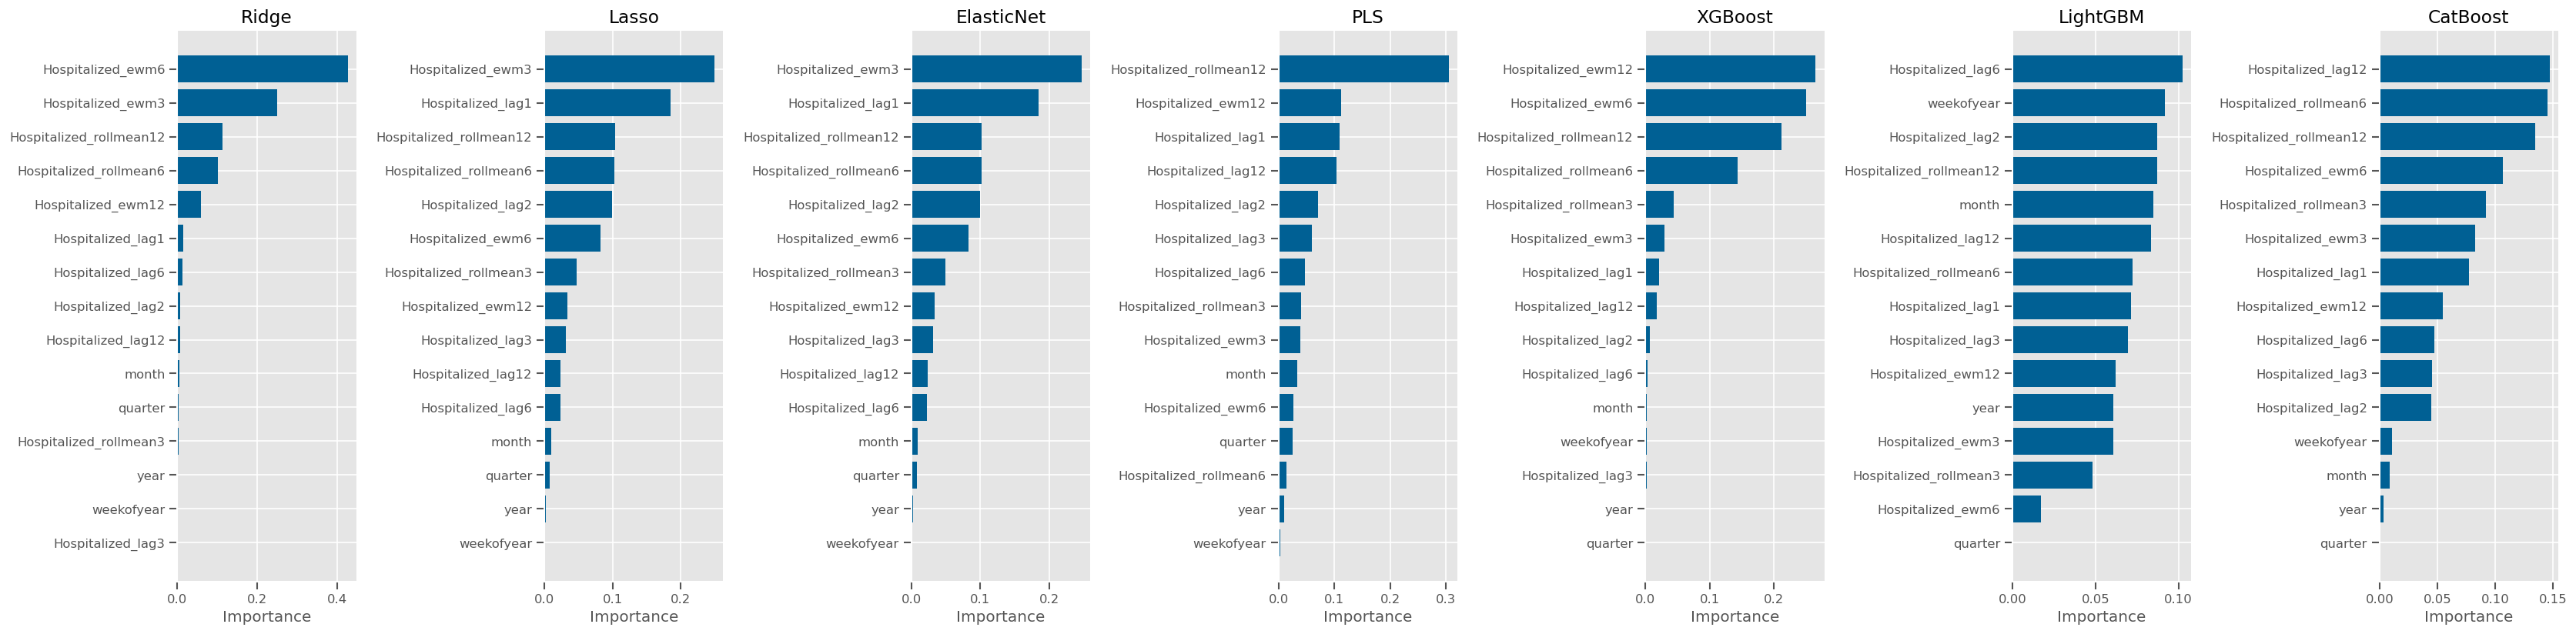

In [19]:
from src.plotting import plot_top_k_feature_importances

fig, axes = plot_top_k_feature_importances(
    feature_importances_monthly_direct,
    k = 20,
)

plt.show()

In [20]:
from src.io_utils import export_panel_results

paths = export_panel_results(
    results=results,
    metrics=metrics,
    output_dir=RESULTS_DIR / "global_monthly",
    experiment_name="one-step-ahead_12m_no_exg",
    save_predictions=True,
    save_metrics=True,
)

paths


{'predictions': WindowsPath('C:/Users/esper/Desktop/injury_forecasting/results/global_monthly/one-step-ahead_12m_no_exg_predictions_long.csv'),
 'metrics_global_train': WindowsPath('C:/Users/esper/Desktop/injury_forecasting/results/global_monthly/one-step-ahead_12m_no_exg_metrics_global_train.csv'),
 'metrics_global_test': WindowsPath('C:/Users/esper/Desktop/injury_forecasting/results/global_monthly/one-step-ahead_12m_no_exg_metrics_global_test.csv'),
 'metrics_by_group_train': WindowsPath('C:/Users/esper/Desktop/injury_forecasting/results/global_monthly/one-step-ahead_12m_no_exg_metrics_by_group_train.csv'),
 'metrics_by_group_test': WindowsPath('C:/Users/esper/Desktop/injury_forecasting/results/global_monthly/one-step-ahead_12m_no_exg_metrics_by_group_test.csv')}

## Direct Multi-step forecast for h=[3,6,12] / monthly

In [21]:
from src.training import (
    multi_step_global_models
)

horizons = [1, 3, 6, 12]

# this function takes internally care of splitting the data into train/test for multi-step ahead forecasting by calling temporal_panel_split
results_multistep = multi_step_global_models(
    horizons=horizons,
    X=X,
    y=y,
    meta=meta,
    date_col="Date",
    train_end="2023-12-01",
    test_size=12,          
    use_linear=True,
    use_tree=True,
    random_state=0,
    n_jobs=-1,
)

metrics_multistep = compute_panel_metrics(
    results=results_multistep,
    group_col="State",
    metric_names=("rmse", "mae"),
)

# Global test metrics across all horizons
metrics_multistep["global"]["test"]


c:\Users\esper\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.304e+04, tolerance: 1.814e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\esper\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.384e+04, tolerance: 1.814e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\esper\Desktop\injury_forecasting\src\splitting.py:100: UserWarning: Requested test_size=12, but only 11 periods exist after train_end. The test set will be truncated.
  warnings.warn(
c:\Users\esper\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: Convergence

,rmse,mae
model,,
CatBoost_h1,5.909537,3.998891
CatBoost_h12,6.291983,4.199756
CatBoost_h3,5.842498,4.014564
CatBoost_h6,5.491621,3.922343
ElasticNet_h1,5.929842,3.995911
ElasticNet_h12,6.436560,4.442699
ElasticNet_h3,5.915778,4.046905
ElasticNet_h6,5.602800,3.942148
Lasso_h1,5.929725,3.995820


In [22]:
from src.io_utils import export_panel_results

paths_multistep = export_panel_results(
    results=results_multistep,
    metrics=metrics_multistep,
    output_dir=RESULTS_DIR / "global_monthly",
    experiment_name="multistep_no_exg",
    save_predictions=True,
    save_metrics=True,
)

paths_multistep

{'predictions': WindowsPath('C:/Users/esper/Desktop/injury_forecasting/results/global_monthly/multistep_no_exg_predictions_long.csv'),
 'metrics_global_train': WindowsPath('C:/Users/esper/Desktop/injury_forecasting/results/global_monthly/multistep_no_exg_metrics_global_train.csv'),
 'metrics_global_test': WindowsPath('C:/Users/esper/Desktop/injury_forecasting/results/global_monthly/multistep_no_exg_metrics_global_test.csv'),
 'metrics_by_group_train': WindowsPath('C:/Users/esper/Desktop/injury_forecasting/results/global_monthly/multistep_no_exg_metrics_by_group_train.csv'),
 'metrics_by_group_test': WindowsPath('C:/Users/esper/Desktop/injury_forecasting/results/global_monthly/multistep_no_exg_metrics_by_group_test.csv')}

## Weekly resolution

In [23]:
weekly_panel = aggregate_panel(
    df,
    date_col='EventDate',
    group_col='State',
    target_cols=("Hospitalized",),
    freq="W-MON",
    agg='sum',
    complete_panel=True
)

weekly_panel.head(), weekly_panel.shape

(     State       Date  Hospitalized
 0  ALABAMA 2015-01-05           0.0
 1  ALABAMA 2015-01-12           2.0
 2  ALABAMA 2015-01-19           4.0
 3  ALABAMA 2015-01-26           6.0
 4  ALABAMA 2015-02-02           3.0,
 (15930, 3))

In [ ]:
weekly_panel.to_csv(
    DATA_DIR / "processed" / "weekly_panel.csv", index=False)

In [24]:
balance_info_wk = check_panel_balance(
    weekly_panel,
    group_col='State',
    date_col='Date'
)

balance_info_wk

{'is_balanced': True,
 'n_groups': 30,
 'n_periods': 531,
 'rows_expected': 15930,
 'rows_actual': 15930,
 'periods_per_group': State
 ALABAMA                 531
 ARKANSAS                531
 COLORADO                531
 CONNECTICUT             531
 DELAWARE                531
 DISTRICT OF COLUMBIA    531
 FLORIDA                 531
 GEORGIA                 531
 IDAHO                   531
 ILLINOIS                531
 KANSAS                  531
 LOUISIANA               531
 MAINE                   531
 MASSACHUSETTS           531
 MISSISSIPPI             531
 MISSOURI                531
 MONTANA                 531
 NEBRASKA                531
 NEW HAMPSHIRE           531
 NEW JERSEY              531
 NEW YORK                531
 NORTH DAKOTA            531
 OHIO                    531
 OKLAHOMA                531
 PENNSYLVANIA            531
 RHODE ISLAND            531
 SOUTH DAKOTA            531
 TEXAS                   531
 WEST VIRGINIA           531
 WISCONSIN               

In [ ]:
import matplotlib.pyplot as plt

state = "ALABAMA"

temp_wk = weekly_panel[weekly_panel['State'] == state]

plt.figure(figsize=(12, 4))
plt.plot(temp_wk['Date'], temp_wk["Hospitalized"], marker='o', label=state)
plt.title(f"Hospitalization per Month - {state}")
plt.show()

In [25]:
from src.features import build_panel_features

X_wk, y_wk, meta_wk = build_panel_features(
    panel_df=weekly_panel,
    target="Hospitalized",
    group_col="State",
    date_col="Date",
    freq="W-MON",
    add_calendar=True,
    add_lags=True,
    add_rolling=True,
    add_ewm=True,
    lags=(1, 2, 4, 8, 12, 24, 52),
    rolling_windows=(12, 24, 52),
    ewm_spans=(12, 24, 52),
    dropna=True,
)

X_wk.head(), y_wk.head(), meta_wk.head()


(   year  month  quarter  weekofyear  Hospitalized_lag1  Hospitalized_lag2  \
 0  2016      1        1           1                4.0                1.0   
 1  2016      1        1           2                3.0                4.0   
 2  2016      1        1           3                9.0                3.0   
 3  2016      1        1           4                8.0                9.0   
 4  2016      2        1           5                6.0                8.0   
 
    Hospitalized_lag4  Hospitalized_lag8  Hospitalized_lag12  \
 0                4.0                0.0                 6.0   
 1                1.0                9.0                 5.0   
 2                1.0                3.0                 7.0   
 3                4.0                5.0                 7.0   
 4                3.0                4.0                 0.0   
 
    Hospitalized_lag24  Hospitalized_lag52  Hospitalized_rollmean12  \
 0                 6.0                 0.0                 4.333333   
 1

In [26]:
print(X_wk.shape, y_wk.shape, meta_wk.shape)

(14370, 17) (14370,) (14370, 2)


In [27]:
from src.splitting import temporal_panel_split

splits_wk = temporal_panel_split(
    X=X_wk,
    y=y_wk,
    meta=meta_wk,
    date_col='Date',
    train_end='2023-12-31',
    test_start='2024-01-01',
    test_size=52
)


In [28]:
print(splits_wk['train'], splits_wk['test'])

{'X':        year  month  quarter  weekofyear  Hospitalized_lag1  Hospitalized_lag2  \
0      2016      1        1           1                4.0                1.0   
1      2016      1        1           2                3.0                4.0   
2      2016      1        1           3                9.0                3.0   
3      2016      1        1           4                8.0                9.0   
4      2016      2        1           5                6.0                8.0   
...     ...    ...      ...         ...                ...                ...   
12505  2023     11        4          48                3.0                8.0   
12506  2023     12        4          49                2.0                3.0   
12507  2023     12        4          50                8.0                2.0   
12508  2023     12        4          51                2.0                8.0   
12509  2023     12        4          52                0.0                2.0   

       Hospitalized_l

In [29]:
from src.models import get_model_configs, instantiate_models

X_train_wk = splits_wk["train"]["X"]
y_train_wk = splits_wk["train"]["y"]

model_configs_wk = get_model_configs(
    n_samples=len(X_train_wk),
    use_linear=True,
    use_tree=True,
    random_state=0,
    n_jobs=-1,
)

models_wk = instantiate_models(model_configs_wk)

list(models_wk.keys())
# ['Ridge', 'Lasso', 'ElasticNet', 'PLS', 'XGBoost', 'LightGBM', 'CatBoost']


['Ridge', 'Lasso', 'ElasticNet', 'PLS', 'XGBoost', 'LightGBM', 'CatBoost']

In [30]:
from src.training import train_and_predict_global_models


# 2. Train + predict
results_wk = train_and_predict_global_models(
    models=models_wk,
    splits=splits_wk,
)

# Example: inspect one model's test predictions
ridge_test_wk = results_wk["Ridge"]["test"]
ridge_test_wk["meta"].head()
ridge_test_wk["y_true"].head()
ridge_test_wk["y_pred"].head()


c:\Users\esper\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.039e+03, tolerance: 4.719e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\esper\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.706e+03, tolerance: 4.719e+01
  model = cd_fast.enet_coordinate_descent(


0    3.883450
1    4.814830
2    4.569731
3    4.486307
4    4.646480
Name: Ridge_pred_test, dtype: float64

In [31]:
from src.evaluation import compute_panel_metrics

metrics_wk = compute_panel_metrics(
    results=results_wk,
    group_col="State",
    metric_names=("rmse", "mae"),
)

global_train_wk = metrics_wk["global"]["train"]
global_test_wk  = metrics_wk["global"]["test"]

by_state_train_wk = metrics_wk["by_group"]["train"]
by_state_test_wk  = metrics_wk["by_group"]["test"]

print("Global test metrics:")
display(global_test_wk)

print("Per-state test metrics (head):")
display(by_state_test_wk.head())


Global test metrics:


,rmse,mae
model,,
CatBoost,2.412823,1.633829
ElasticNet,2.413860,1.633880
Lasso,2.413672,1.633980
LightGBM,2.413255,1.631822
PLS,2.414649,1.631366
Ridge,2.415397,1.634191
XGBoost,2.409878,1.624474


Per-state test metrics (head):


rmse       mae
State   model                         
ALABAMA CatBoost    2.228429  1.826023
        ElasticNet  2.262964  1.894413
        Lasso       2.263185  1.895023
        LightGBM    2.175123  1.769117
        PLS         2.246010  1.867431

## with extra features

In [ ]:
from src.features import compute_naics_mix

naics_mix = compute_naics_mix(
    df=df,
    naics_col="Primary NAICS",
    date_col="EventDate",
    state_col="State",
    freq="MS",
    top_k=10,
    out_date_col="Date"
)

In [ ]:
naics_mix.head()

In [ ]:
naics_panel = monthly_panel.merge(
    naics_mix,
    on=['State', 'Date'],
    how="left",
)

In [ ]:
naics_panel.head()

In [ ]:
share_cols = [c for c in naics_panel.columns if c.startswith("share_NAICS2_")]
naics_panel[share_cols] = naics_panel[share_cols].fillna(0.0)

In [ ]:
from src.features import build_panel_features

X_naics, y_naics, meta_naics = build_panel_features(
    panel_df=naics_panel,
    target="Hospitalized",
    group_col="State",
    date_col="Date",
    freq="MS",
    add_calendar=True,
    add_lags=True,
    add_rolling=True,
    add_ewm=True,
    state_encoding="dummy",
    naics_mix_cols=share_cols,  # <- lag-1 versions of these will be created
)


In [ ]:
X_naics.head()

In [ ]:

splits_naics = temporal_panel_split(
    X=X_naics,
    y=y_naics,
    meta=meta_naics,
    date_col='Date',
    train_end='2023-12-01',
    test_start='2024-01-01',
    test_size=12
)


In [ ]:
print("Train window:",
      splits_naics["train"]["meta"]["Date"].min(),
      "→",
      splits_naics["train"]["meta"]["Date"].max())

print("Test window:",
      splits_naics["test"]["meta"]["Date"].min(),
      "→",
      splits_naics["test"]["meta"]["Date"].max())

In [ ]:


X_train_naics = splits_naics["train"]["X"]
y_train_naics = splits_naics["train"]["y"]

model_configs_naics = get_model_configs(
    n_samples=len(X_train_naics),
    use_linear=True,
    use_tree=True,
    random_state=0,
    n_jobs=-1,
)

models_naics = instantiate_models(model_configs_naics)

list(models_naics.keys())
# ['Ridge', 'Lasso', 'ElasticNet', 'PLS', 'XGBoost', 'LightGBM', 'CatBoost']


In [ ]:

# 2. Train + predict
results_naics = train_and_predict_global_models(
    models=models_naics,
    splits=splits_naics,
)

# Example: inspect one model's test predictions
ridge_test_naics = results_naics["Ridge"]["test"]
ridge_test_naics["meta"].head()
ridge_test_naics["y_true"].head()
ridge_test_naics["y_pred"].head()


In [ ]:
metrics_naics = compute_panel_metrics(
    results=results_naics,
    group_col="State",
    metric_names=("rmse", "mae"),
)

global_train_naics = metrics_naics["global"]["train"]
global_test_naics  = metrics_naics["global"]["test"]

by_state_train_naics = metrics_naics["by_group"]["train"]
by_state_test_naics  = metrics_naics["by_group"]["test"]

print("Global test metrics:")
display(global_test_naics)

print("Per-state test metrics (head):")
display(by_state_test_naics.head())

In [ ]:
from src.evaluation import compute_feature_importances
feature_importances_naics = compute_feature_importances(
    models=models_naics,
    X=X_naics,
)

feature_importances_naics.head()

In [ ]:
from src.plotting import plot_top_k_feature_importances

fig, axes = plot_top_k_feature_importances(
    feature_importances_naics,
    k = 20,
)

plt.show()

In [ ]:
feature_importances_naics['Ridge'].sort_values()

### To compare monthly and weekly forecasts, we have to use the multi-step forecast strategy. This way we can set monthly horizon=1 vs. weekly horizon=4.  

In [38]:
from src.training import (
    multi_step_global_models
)

horizons = [4, 13, 26, 52]

# this function takes internally care of splitting the data into train/test for multi-step ahead forecasting by calling temporal_panel_split
results_multistep_wk = multi_step_global_models(
    horizons=horizons,
    X=X_wk,
    y=y_wk,
    meta=meta_wk,
    date_col="Date",
    train_end="2023-12-27",
    test_start="2024-01-01",
    test_size=12,          
    use_linear=True,
    use_tree=True,
    random_state=0,
    n_jobs=-1,
)



c:\Users\esper\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.594e+04, tolerance: 4.714e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\esper\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.881e+04, tolerance: 4.714e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\esper\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.683e+03, toleranc

In [39]:
wk_months = set(results_multistep_wk["Ridge_h4"]["test"]["meta"]["Date"])
mo_months = set(results_multistep["Ridge_h1"]["test"]["meta"]["Date"])



In [40]:
print(wk_months)
print(mo_months)

{Timestamp('2024-01-15 00:00:00'), Timestamp('2024-01-29 00:00:00'), Timestamp('2024-02-19 00:00:00'), Timestamp('2024-02-05 00:00:00'), Timestamp('2024-02-26 00:00:00'), Timestamp('2024-01-22 00:00:00'), Timestamp('2024-03-04 00:00:00'), Timestamp('2024-03-18 00:00:00'), Timestamp('2024-01-01 00:00:00'), Timestamp('2024-01-08 00:00:00'), Timestamp('2024-03-11 00:00:00'), Timestamp('2024-02-12 00:00:00')}
{Timestamp('2024-07-01 00:00:00'), Timestamp('2024-08-01 00:00:00'), Timestamp('2024-10-01 00:00:00'), Timestamp('2024-04-01 00:00:00'), Timestamp('2024-11-01 00:00:00'), Timestamp('2024-01-01 00:00:00'), Timestamp('2024-06-01 00:00:00'), Timestamp('2024-05-01 00:00:00'), Timestamp('2024-02-01 00:00:00'), Timestamp('2024-09-01 00:00:00'), Timestamp('2024-12-01 00:00:00'), Timestamp('2024-03-01 00:00:00')}
